# TAESDXL Training

This notebook demonstrates how to train a tiny encoder / decoder for the SDXL latent space.

## Config

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import glob
import random
from collections import namedtuple
from functools import lru_cache
from pathlib import Path

import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm

th.backends.cudnn.benchmark = True

In [2]:
class Config:
    # Train the encoder?
    train_encoder = True
    # Train the decoder?
    train_decoder = True

    # Dataset folder to search for images in
    dataset_path = "dataset"
    
    # Height / width of patches used for training (always need to finetune on 256x256 at the end)
    hw = 96
    # Number of patches to show in visualizations
    n_demo = 1024 // hw
    
    # Device and dtype to use for reference model
    device = "cuda"
    ref_dtype = th.float16

    # dtype to use for trained model
    dtype = th.float32

## Dataset

The dataset code will load images from the dataset folder and crop out random patches.

In [3]:
def show(x):
    if not isinstance(x, th.Tensor) or x.ndim == 4:
        x = th.cat(tuple(x), -1)
    display(TF.to_pil_image(x))


def show_latents(x):
    show(F.interpolate(x[:, :3].add(0.5).mul_(0.3).clamp_(0, 1), scale_factor=8))


def random_resize_crop(im, patch_hw):
    # pad as needed in case there are tiny images
    if min(im.size) < patch_hw:
        px = patch_hw - im.width
        py = patch_hw - im.height
        im = TF.pad(
            im, (px // 2, px - px // 2, py // 2, py - py // 2), padding_mode="reflect"
        )
    crop_hw = random.randint(patch_hw, max(patch_hw, min(im.size)))
    crop_x = random.randrange(0, im.width - crop_hw) if im.width > crop_hw else 0
    crop_y = random.randrange(0, im.height - crop_hw) if im.height > crop_hw else 0
    patch = im.crop((crop_x, crop_y, crop_x + crop_hw, crop_y + crop_hw))
    return patch.resize((patch_hw, patch_hw), Image.BICUBIC)


class Dataset(th.utils.data.Dataset):
    def __init__(self, p, patch_hw, image_extensions=["jpg", "png"]):
        # no pathlib glob here, pathlib glob is bad with symlinks and hidden files
        self.ims = sum([glob.glob(p + f"/**/*.{ext}", recursive=True) for ext in image_extensions], [])
        self.patch_hw = patch_hw

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, i):
        im = Image.open(self.ims[i])
        im = random_resize_crop(im, self.patch_hw)
        im = im.convert("RGB")
        im = TF.pil_to_tensor(im)
        return im


d_train = Dataset(Config.dataset_path, Config.hw)
print(f"Got {len(d_train)} images from {Config.dataset_path}")

Got 9753 images from dataset


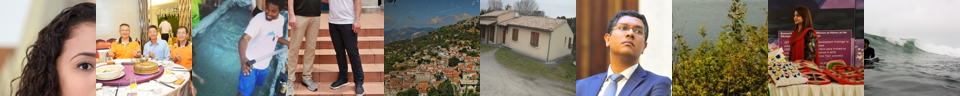

In [4]:
def demo_cpu_dataset(dataset):
    show(random.choice(dataset) for _ in range(Config.n_demo))


demo_cpu_dataset(d_train)

## SDXL Encoder

The reference SDXL VAE will be used to convert patches into latents.

/home/ubuntu/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/ubuntu/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Original Images


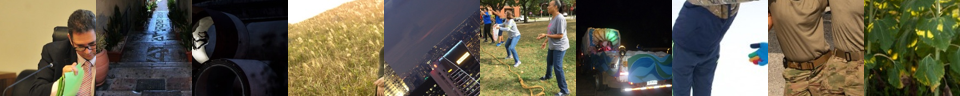

Latents


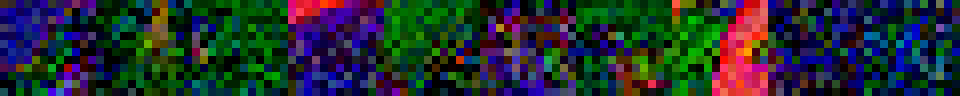

Decoded Images


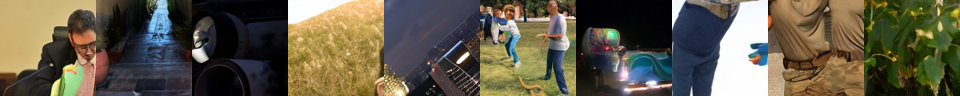

In [5]:
class DiffusersVAEWrapper:
    def __init__(self):
        from diffusers import AutoencoderKL

        self.vae = (
            AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix")
            .to(device=Config.device, dtype=Config.ref_dtype)
            .eval()
            .requires_grad_(False)
        )
        self.sf = self.vae.config.scaling_factor

    def encode(self, x):
        return (
            self.vae.encode(x.to(device=Config.device, dtype=Config.ref_dtype).mul(2).sub_(1))
            .latent_dist.sample()
            .mul_(self.sf)
            .to(device=x.device, dtype=x.dtype)
        )

    def decode(self, x):
        return (
            self.vae.decode(x.to(device=Config.device, dtype=Config.ref_dtype).div(self.sf))
            .sample.mul_(0.5)
            .add_(0.5)
            .clamp_(0, 1)
            .to(device=x.device, dtype=x.dtype)
        )


vae_ref = DiffusersVAEWrapper()


def demo_vae_wrapper(dataset, vae):
    ims = (
        th.stack([random.choice(dataset) for _ in range(Config.n_demo)], 0)
        .to(device=Config.device, dtype=Config.ref_dtype)
        .div_(255.0)
    )
    print("Original Images")
    show(ims)

    print("Latents")
    latents = vae.encode(ims)
    show_latents(latents)

    print("Decoded Images")
    show(vae.decode(latents))


demo_vae_wrapper(d_train, vae_ref)

In [6]:
Sample = namedtuple("Sample", ("im", "latent"))


def gpu_preprocess(ims):
    ims = ims.to(device=Config.device, dtype=Config.ref_dtype).div_(255.0)
    latent = vae_ref.encode(ims)
    return Sample(ims.to(Config.dtype), latent.to(Config.dtype))

## TAESDXL Model

Our TAESDXL model will be trained to convert SDXL latents to and from RGB images.
We'll also load a pretrained TAESDXL model for reference.

In [7]:
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taesd/main/taesd.py
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taesd/main/taesdxl_encoder.pth
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taesd/main/taesdxl_decoder.pth

In [8]:
from taesd import TAESD

def count_params(label, m):
    n_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
    n_params_str = f"{n_params/1e6:.2f}M"
    return f"{label.ljust(16)}{n_params_str.rjust(8)} params"


model = TAESD(encoder_path=None, decoder_path=None).to(device=Config.device, dtype=Config.dtype)
nn.init.constant_(model.decoder[-1].bias, 0.5)

print(count_params("model", model))
print(count_params(".encoder", model.encoder))
print(count_params(".decoder", model.decoder))

def weight_average(w_prev, w_new, n):
    alpha = min(0.95, n / 10)
    return alpha * w_prev + (1 - alpha) * w_new


avg_model = th.optim.swa_utils.AveragedModel(model, avg_fn=weight_average)

model              2.45M params
.encoder           1.22M params
.decoder           1.22M params


In [9]:
pretrained_model = TAESD(encoder_path="taesdxl_encoder.pth", decoder_path="taesdxl_decoder.pth")
pretrained_model = pretrained_model.to(device=Config.device, dtype=Config.dtype).eval().requires_grad_(False)

Latents (Reference Encoder)


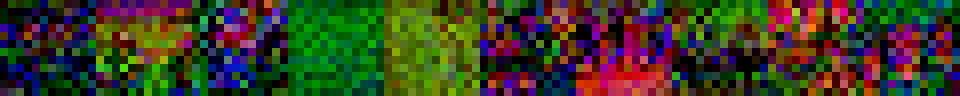

Latents (Pretrained Encoder)


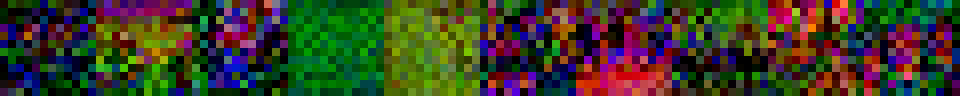

Latents (Our Encoder)


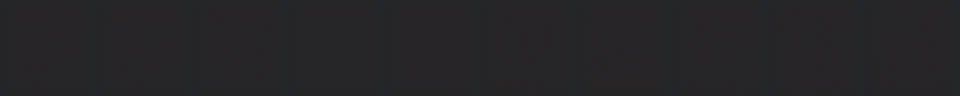

Decoded Images (Reference Decoder)


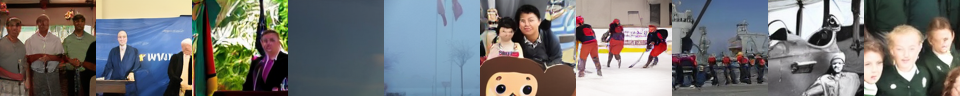

Decoded Images (Pretrained Decoder)


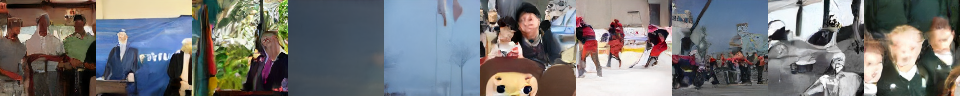

Decoded Images (Our Decoder)


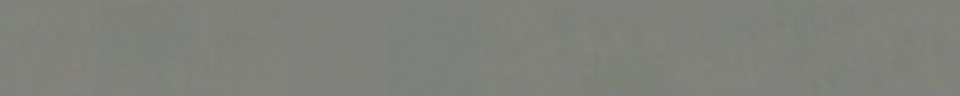

Original Images


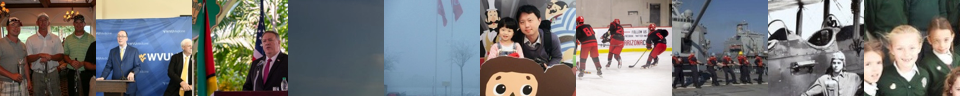

In [10]:
@th.no_grad()
def demo_taesd(xb, model, n=Config.n_demo):
    print("Latents (Reference Encoder)")
    show_latents(xb.latent[:n])
    
    print("Latents (Pretrained Encoder)")
    show_latents(pretrained_model.encoder(xb.im[:n]))
    
    print("Latents (Our Encoder)")
    show_latents(model.encoder(xb.im[:n]))

    print("Decoded Images (Reference Decoder)")
    show(vae_ref.decode(xb.latent[:n]))
    
    print("Decoded Images (Pretrained Decoder)")
    show(pretrained_model.decoder(xb.latent[:n]).clamp_(0, 1))

    print("Decoded Images (Our Decoder)")
    show(model.decoder(xb.latent[:n]).clamp_(0, 1))
    
    print("Original Images")
    show(xb.im[:n])


demo_taesd(gpu_preprocess(next(iter(th.utils.data.DataLoader(d_train, batch_size=Config.n_demo, shuffle=True)))), avg_model.module)

## Seraena

Seraena will be used to generate the training guidance for our decoder model.

In [12]:
from seraena import Seraena

seraena = Seraena(3, 4).to(Config.device)
print(count_params("seraena", seraena))

seraena            7.48M params


## Training Loop

In [13]:
import datetime
import os
import time

from IPython.display import clear_output


class Visualizer:
    def __init__(self):
        self.losses_since_last_vis = []
        self.avg_losses = []
        self.steps = []
        self.step = 0
        self.t_last_vis = 0
        self.t_last_save = 0
        self.t_start = None
        folder, idx = (
            datetime.datetime.now().strftime("%Y_%m_%d")
            + "_taesdxl_example_training_logs",
            0,
        )
        while Path(f"{folder}_{idx}").exists():
            idx += 1
        self.folder = Path(f"{folder}_{idx}")
        self.folder.mkdir()

    @th.no_grad()
    def __call__(
        self,
        model,
        seraena,
        t,
        debug,
        losses,
        n_demo=Config.n_demo,
        visualize=False,
    ):
        self.losses_since_last_vis.append(sum(losses.values()).item())
        avg_loss = sum(self.losses_since_last_vis) / len(self.losses_since_last_vis)
        self.step += 1
        if self.t_start is None:
            self.t_start = t
        if visualize:
            clear_output(wait=True)
            disc_idx = th.randperm(len(debug["disc_in"]))[:n_demo]
            print("Seraena Input Images / Latents")
            show(debug["disc_in"][disc_idx].clamp(0, 1))
            show_latents(debug["disc_in_ctx"][disc_idx])
            print("Seraena Predictions")
            show(
                F.interpolate(
                    debug["disc_pred"][disc_idx].mean(1, keepdim=True), debug["xb"].im.shape[-2:]
                ).clamp(0, 1)
            )
            print("Seraena Targets")
            show(
                F.interpolate(
                    debug["disc_targets"][disc_idx].mean(1, keepdim=True), debug["xb"].im.shape[-2:]
                ).clamp(0, 1)
            )
            print(f"Seraena Loss: {debug['disc_loss']:.5f}")
            
            demo_taesd(debug["xb"], model)
            if Config.train_decoder:
                print("Total Decoder Corrections (negative grad)")
                show((debug["decoder_grad"])[:n_demo].neg().add(0.5).clamp(0, 1))

            self.steps.append(self.step)
            self.avg_losses.append(avg_loss)
            self.losses_since_last_vis = []
            plt.title("Losses")
            plt.plot(
                self.steps,
                self.avg_losses,
                label=f"{self.folder} {self.avg_losses[-1]:.5f}",
            )
            plt.gcf().set_size_inches(16, 4)
            plt.ylim(0, 1.5 * self.avg_losses[-1])
            plt.legend()
            if t > self.t_last_save + 120:
                th.save(model.state_dict(), self.folder / "model.pth")
                th.save(seraena.state_dict(), trainer.visualizer.folder / "seraena.pth")
                th.save((self.steps, self.avg_losses), self.folder / "stats.pth")
                plt.gcf().savefig(self.folder / "stats.jpg")
                self.t_last_save = t
            plt.show()
            self.t_last_vis = t
        print(
            f"\r{self.step: 5d} Steps; {int(t - self.t_start): 3d} Seconds; "
            f"{60 * self.step / (t - self.t_start + 1):.1f} Steps / Min; "
            f"{len(debug['xb'].im) * 60 * self.step / (t - self.t_start + 1):.1f} Images / Min; "
            f"Loss {avg_loss:.5f}",
            end="",
        )


class Trainer:
    def __init__(self, dataset, model, avg_model, seraena, batch_size=32):
        self.model = model
        self.avg_model = avg_model
        self.last_avg_time = time.time()
        self.opt = th.optim.AdamW(model.parameters(), 3e-5, betas=(0.9, 0.99))
        num_workers = min(
            12,
            len(os.sched_getaffinity(0))
            if hasattr(os, "sched_getaffinity")
            else os.cpu_count(),
        )
        self.dataloader = th.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=num_workers,
        )
        self.scaler = th.cuda.amp.GradScaler()
        self.dl_iter = iter(self.dataloader)
        self.seraena = seraena
        self.visualizer = Visualizer()
        self.n_steps = 0

    def avg_model_step(self, t):
        if t > self.last_avg_time + 2:
            self.avg_model.update_parameters(self.model)
            self.last_avg_time = t

    def get_batch(self):
        try:
            batch = next(self.dl_iter)
        except StopIteration:
            self.dl_iter = iter(self.dataloader)
            batch = next(self.dl_iter)
        return gpu_preprocess(batch)

    def train(self, n_seconds):
        self.model.train()
        start_time = time.time()
        while time.time() < start_time + n_seconds:
            self.train_step(time.time())

    def train_step(self, t):
        xb = self.get_batch()
        
        debug = {"xb": xb}
        losses = {}

        if Config.train_encoder:
            with th.cuda.amp.autocast():
                encoded = self.model.encoder(xb.im)
                losses["encoder"] = F.mse_loss(encoded, xb.latent)
                debug["encoded"] = encoded.detach()

        if Config.train_decoder:
            decoder_grad = th.zeros_like(xb.im).requires_grad_(True)
            with th.cuda.amp.autocast():
                decoded = self.model.decoder(xb.latent) + decoder_grad
            target, seraena_debug = self.seraena.step_and_make_correction_targets(xb.im, decoded, xb.latent)
            debug.update(seraena_debug)
            debug["target"] = target
            with th.cuda.amp.autocast():
                losses["decoder"] = F.mse_loss(decoded, target)
                debug["decoded"] = decoded.detach()

        self.opt.zero_grad()
        self.scaler.scale(sum(losses.values())).backward()
        self.scaler.step(self.opt)
        self.scaler.update()
        self.avg_model_step(t)

        debug["decoder_grad"] = decoder_grad.grad.detach()
        self.visualizer(
            self.avg_model.module,
            self.seraena,
            t,
            debug,
            losses,
            visualize=(t > self.visualizer.t_last_vis + 30),
        )
        self.n_steps += 1


trainer = Trainer(d_train, model, avg_model, seraena)

Seraena Input Images / Latents


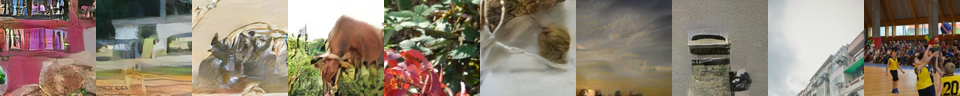

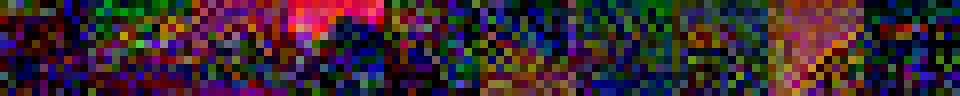

Seraena Predictions


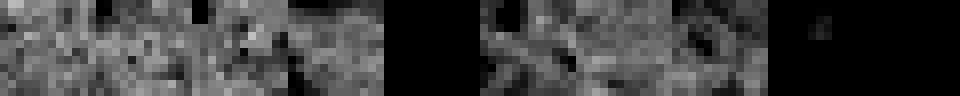

Seraena Targets


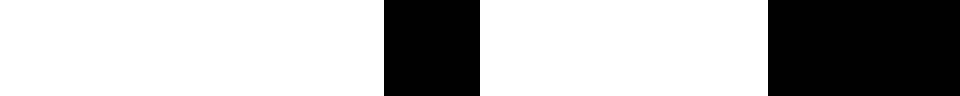

Seraena Loss: 0.60624
Latents (Reference Encoder)


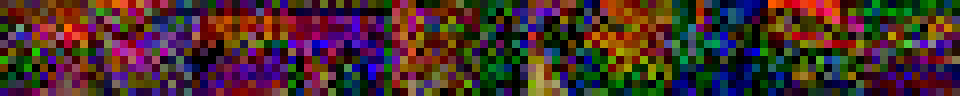

Latents (Pretrained Encoder)


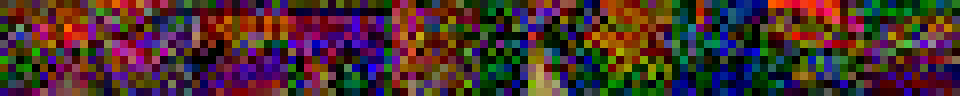

Latents (Our Encoder)


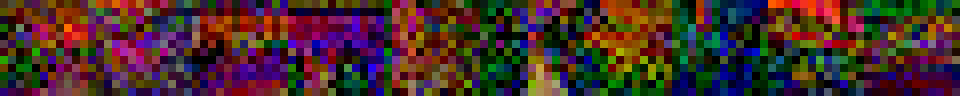

Decoded Images (Reference Decoder)


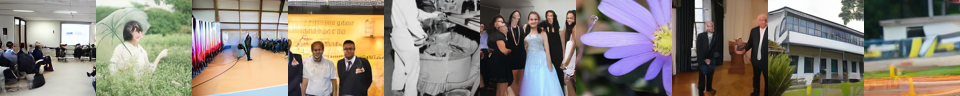

Decoded Images (Pretrained Decoder)


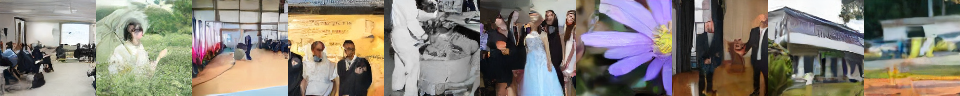

Decoded Images (Our Decoder)


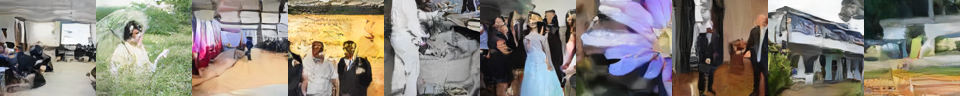

Original Images


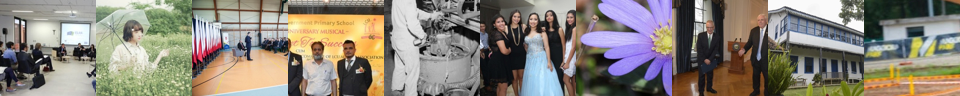

Total Decoder Corrections (negative grad)


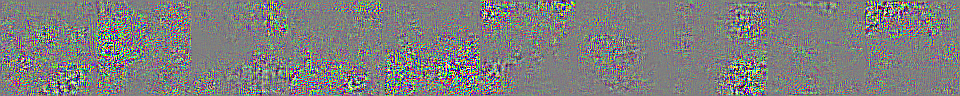

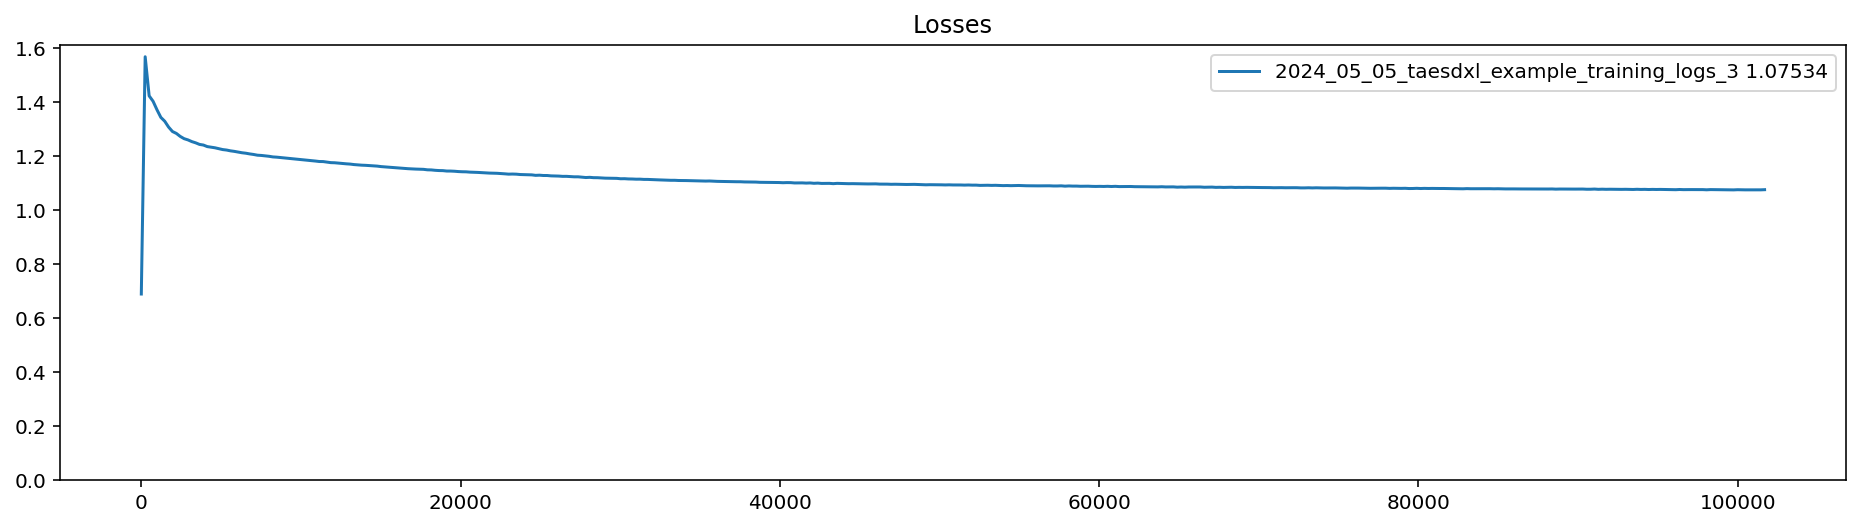

 101753 Steps;  12635 Seconds; 483.1 Steps / Min; 15460.3 Images / Min; Loss 1.07416

KeyboardInterrupt: 

In [14]:
trainer.train(n_seconds=24 * 60 * 60)